# 비선형 분류 모형 종합 비교

경사하강법, KNN, SVM, 랜덤포레스트, XGBoost, LightGBM, CatBoost 결과를 불러와 **주요 성능 비교**, **과적합 여부**, **채택 모형 SHAP 분석**을 수행합니다.

**사전 조건:** 각 `new_*.ipynb`를 실행해 `results/*.pkl`이 생성되어 있어야 합니다.

## 라이브러리 및 결과 로드

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sb
import shap

my_dpi = 100

results_dir = 'results'
pkl_names = [
    'new_경사하강법', 'new_KNN', 'new_SVM', 'new_랜덤포레스트',
    'new_XGBoost', 'new_LightGBM', 'new_CatBoost'
]

results = {}
for name in pkl_names:
    path = os.path.join(results_dir, name + '.pkl')
    if os.path.isfile(path):
        with open(path, 'rb') as f:
            results[name] = pickle.load(f)
        print(f'Loaded: {name}')
    else:
        print(f'Skip (not found): {path}')

if not results:
    raise SystemExit('결과 파일이 없습니다. 각 new_*.ipynb를 먼저 실행하세요.')

Loaded: new_경사하강법
Loaded: new_KNN
Loaded: new_SVM
Skip (not found): results\new_랜덤포레스트.pkl
Loaded: new_XGBoost
Loaded: new_LightGBM
Loaded: new_CatBoost


## 1. 주요 성능 비교표

In [2]:
score_list = []
for name, d in results.items():
    df = d['score_df'].copy()
    df.index = [name]
    score_list.append(df)

score_compare = pd.concat(score_list, axis=0)
score_compare = score_compare.sort_values('AUC', ascending=False)
display(score_compare)

,의사결정계수(R2),정확도(Accuracy),정밀도(Precision),재현율(Recall),위양성율(Fallout),특이성(TNR),F1 Score,AUC
new_LightGBM,0.836,0.964,0.963,0.930,0.018,0.982,0.946,0.990
new_XGBoost,0.829,0.962,0.949,0.939,0.026,0.974,0.944,0.989
new_CatBoost,0.828,0.964,0.967,0.926,0.016,0.984,0.946,0.988
new_SVM,0.559,0.888,0.849,0.814,0.074,0.926,0.831,0.945
new_KNN,0.379,0.811,0.894,0.497,0.030,0.970,0.639,0.916
new_경사하강법,0.375,0.829,0.716,0.818,0.165,0.835,0.763,0.897


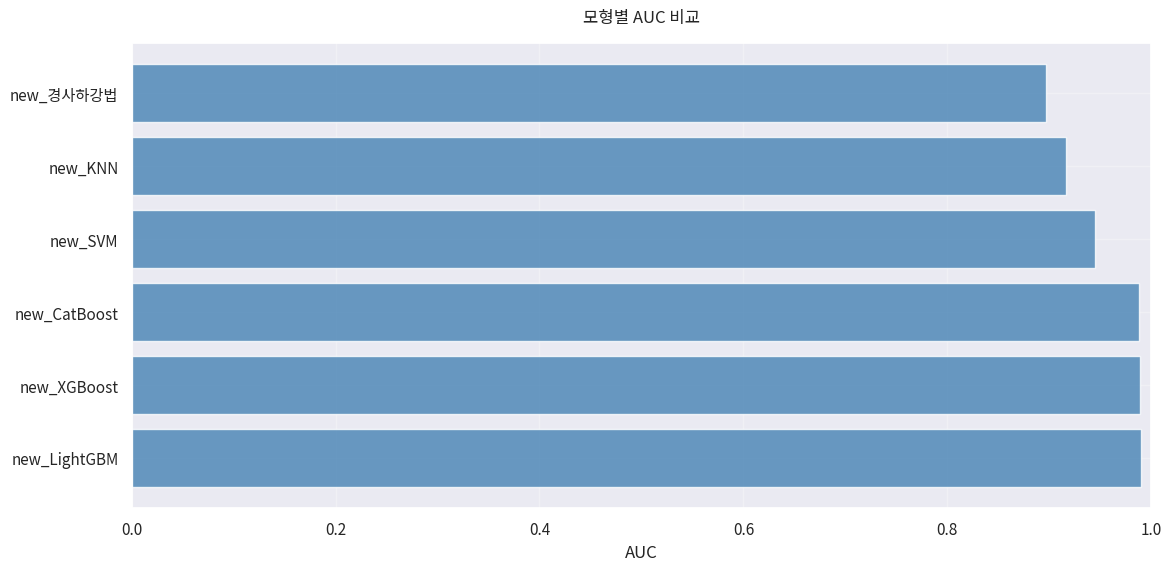

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(1200/my_dpi, 600/my_dpi), dpi=my_dpi)
x_pos = range(len(score_compare))
ax.barh(x_pos, score_compare['AUC'], color='steelblue', alpha=0.8)
ax.set_yticks(x_pos)
ax.set_yticklabels(score_compare.index)
ax.set_xlabel('AUC')
ax.set_title('모형별 AUC 비교')
ax.set_xlim(0, 1)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

## 2. 과적합 여부 비교

In [4]:
result_list = []
for name, d in results.items():
    df = d['result_df'].copy()
    df.index = [name]
    df['과적합_판정'] = d.get('overfit_status', '-')
    result_list.append(df)

overfit_compare = pd.concat(result_list, axis=0)
overfit_compare = overfit_compare.reindex(score_compare.index)
display(overfit_compare)

,Train ROC_AUC 평균,CV ROC_AUC 평균,CV ROC_AUC 표준편차,Train/CV 비율,CV 변동성 비율,판정 결과,과적합_판정
new_LightGBM,0.998,0.993,0.002,0.005,0.002,✅ 일반화 양호,✅ 일반화 양호
new_XGBoost,0.997,0.993,0.002,0.004,0.002,✅ 일반화 양호,✅ 일반화 양호
new_CatBoost,1.000,0.992,0.001,0.007,0.001,✅ 일반화 양호,✅ 일반화 양호
new_SVM,1.000,0.946,0.007,0.054,0.007,⚠ 판단 보류,⚠ 판단 보류
new_KNN,1.000,0.909,0.006,0.091,0.006,⚠ 판단 보류,⚠ 판단 보류
new_경사하강법,0.898,0.883,0.012,0.015,0.012,✅ 일반화 양호,✅ 일반화 양호


## 3. 채택 모형 선정 (AUC 기준 1위)

In [5]:
best_name = score_compare.index[0]
best_auc = score_compare.loc[best_name, 'AUC']
best_status = results[best_name].get('overfit_status', '-')

print(f'채택 모형: {best_name}')
print(f'AUC: {best_auc}')
print(f'과적합 판정: {best_status}')

채택 모형: new_LightGBM
AUC: 0.99
과적합 판정: ✅ 일반화 양호


## 4. 채택 모형 SHAP 분석

In [ ]:
best = results[best_name]
estimator = best['estimator']
x_train = best['x_train']

X_train_transformed = estimator.named_steps['preprocess'].transform(x_train)
feature_names = estimator.named_steps['preprocess'].get_feature_names_out()
X_train_df = DataFrame(X_train_transformed, columns=feature_names, index=x_train.index)
inner_model = estimator.named_steps['model']

# Tree / Linear / Kernel Explainer 구분
model_class = type(inner_model).__name__
tree_like = model_class in ('RandomForestClassifier', 'XGBClassifier', 'LGBMClassifier', 'CatBoostClassifier')
linear_like = model_class == 'SGDClassifier'

if tree_like:
    explainer = shap.TreeExplainer(inner_model, data=X_train_df)
    shap_values = explainer.shap_values(X_train_df)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
    plot_data = X_train_df
elif linear_like:
    masker = shap.maskers.Independent(X_train_df)
    explainer = shap.LinearExplainer(inner_model, masker=masker)
    shap_values = explainer.shap_values(X_train_df)
    plot_data = X_train_df
else:
    background = shap.sample(X_train_df, min(100, len(X_train_df)))
    explainer = shap.KernelExplainer(estimator.predict_proba, background)
    plot_data = X_train_df.sample(n=min(150, len(X_train_df)), random_state=52)
    shap_values = explainer.shap_values(plot_data, nsamples=50)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]

shap.summary_plot(shap_values, plot_data, show=False)
fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.title(f'SHAP Summary Plot - 채택 모형: {best_name}', fontsize=10, pad=10)
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
shap_df = DataFrame(shap_values, columns=feature_names, index=plot_data.index)
summary_df = DataFrame({
    'feature': shap_df.columns,
    'mean_abs_shap': shap_df.abs().mean().values,
    'mean_shap': shap_df.mean().values,
})
summary_df = summary_df.sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)
summary_df['direction'] = np.where(
    summary_df['mean_shap'] > 0, '양(+) 경향',
    np.where(summary_df['mean_shap'] < 0, '음(-) 경향', '혼합/미약')
)
display(summary_df.head(25))